## Análise de dados e testes estatísticos

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind

# Base dados
df_base = pd.read_csv('/content/drive/MyDrive/Case Ifood/df_base_tratada.csv')

print(df_base.head())
print(df_base['grupo'].value_counts())

                                         customer_id    grupo  num_pedidos  \
0  755e1fa18f25caec5edffb188b13fd844b2af8cf5adedc...   target           19   
1  b821aa8372b8e5b82cdc283742757df8c45eecdd72adf4...  control            6   
2  d425d6ee4c9d4e211b71da8fc60bf6c5336b2ea9af9cc0...  control           31   
3  6a7089eea0a5dc294fbccd4fa24d0d84a90c1cc12e829c...   target           10   
4  dad6b7e222bab31c0332b0ccd9fa5dbd147008facd268f...  control            1   

   gasto_total  cliente_ativo  ticket_medio  fez_pedido  
0       229.00           True     12.052632        True  
1       287.88           True     47.980000        True  
2      2004.59           True     64.664194        True  
3       445.43           True     44.543000        True  
4        23.00           True     23.000000        True  
grupo
target     445925
control    360542
Name: count, dtype: int64


### KPIs

In [4]:
def calcular_kpis(df):
    retencao = (df['num_pedidos'] > 1).mean() # Se fez mais de 1 pedido
    num_pedidos_medio = df['num_pedidos'].mean()
    ticket_medio = df['ticket_medio'].mean()
    gasto_medio = df['gasto_total'].mean()
    return retencao, num_pedidos_medio, ticket_medio, gasto_medio

kpis = {}

for grupo in df_base['grupo'].unique():
    df_g = df_base[df_base['grupo'] == grupo]
    kpis[grupo] = calcular_kpis(df_g)

print("KPIs por grupo:")
for grupo, vals in kpis.items():
    print(f"{grupo}:")
    print(f"  Taxa de retencao: {vals[0]:.2%}")
    print(f"  Número médio de pedidos: {vals[1]:.2f}")
    print(f"  Ticket médio: R$ {vals[2]:.2f}")
    print(f"  Gasto médio por usuário: R$ {vals[3]:.2f}")

KPIs por grupo:
target:
  Taxa de retencao: 79.51%
  Número médio de pedidos: 4.79
  Ticket médio: R$ 47.83
  Gasto médio por usuário: R$ 228.75
control:
  Taxa de retencao: 74.70%
  Número médio de pedidos: 4.23
  Ticket médio: R$ 48.01
  Gasto médio por usuário: R$ 202.67


### Testes estatísticos


In [6]:
# Teste Z para diferença de proporção (taxa de retencao)
successes = [(df_base[df_base['grupo']=='target']['num_pedidos'] > 1).sum(),
             (df_base[df_base['grupo']=='control']['num_pedidos'] > 1).sum()]
nobs = [len(df_base[df_base['grupo']=='target']),
        len(df_base[df_base['grupo']=='control'])]

stat, pval = proportions_ztest(successes, nobs)
print(f"\nTeste Z para taxa de retencao: estatística={stat:.3f}, p-valor={pval:.4f}")

# Teste t para diferença de médias (número médio de pedidos)
target_pedidos = df_base[df_base['grupo']=='target']['num_pedidos']
control_pedidos = df_base[df_base['grupo']=='control']['num_pedidos']
stat_t, pval_t = ttest_ind(target_pedidos, control_pedidos, equal_var=False)
print(f"Teste t para número médio de pedidos: estatística={stat_t:.3f}, p-valor={pval_t:.4f}")

# Teste t para diferença de médias (ticket médio)
target_ticket = df_base[df_base['grupo']=='target']['ticket_medio'].dropna()
control_ticket = df_base[df_base['grupo']=='control']['ticket_medio'].dropna()
stat_ticket, pval_ticket = ttest_ind(target_ticket, control_ticket, equal_var=False)
print(f"Teste t para ticket médio: estatística={stat_ticket:.3f}, p-valor={pval_ticket:.4f}")

# Teste t para diferença de médias (gasto total médio por usuário)
target_gasto = df_base[df_base['grupo']=='target']['gasto_total'].dropna()
control_gasto = df_base[df_base['grupo']=='control']['gasto_total'].dropna()
stat_gasto, pval_gasto = ttest_ind(target_gasto, control_gasto, equal_var=False)
print(f"Teste t para gasto médio: estatística={stat_gasto:.3f}, p-valor={pval_gasto:.4f}")



Teste Z para taxa de retencao: estatística=51.229, p-valor=0.0000
Teste t para número médio de pedidos: estatística=44.250, p-valor=0.0000
Teste t para ticket médio: estatística=-0.808, p-valor=0.4190
Teste t para gasto médio: estatística=24.313, p-valor=0.0000


Para o primeiro teste temos que a hipótese nula é que as proporções são iguais nos dois grupos. Considerando um nível de significância de 0.05, não rejeitamos a hipótese nula, ou seja, **as proporções parece ser diferentes nos dois grupos.**

Para os demais testes, a hipótese nula diz que as médias são iguais nos dois grupos. Sendo assim, considerando um nível de significância de 0.05, podemos afirmar que a **média do número de pedidos e do gasto médio é diferente nos dois grupos**.

### Visualizações

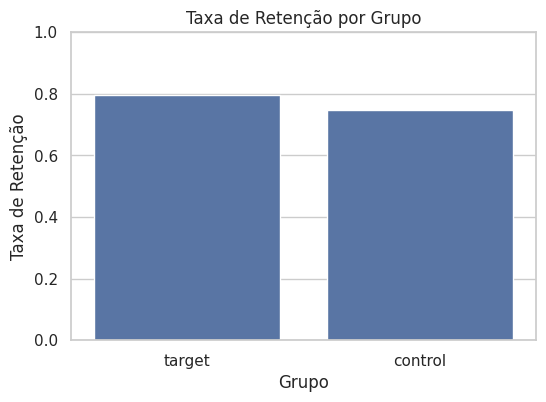

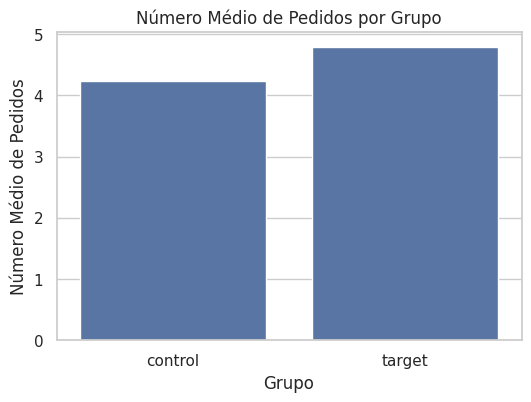

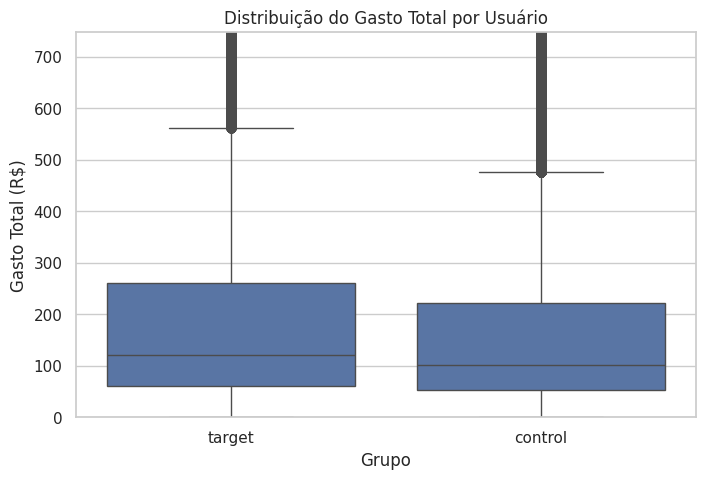

In [9]:
sns.set(style="whitegrid")

# Taxa de retencao
taxa_conv = pd.DataFrame({
    'grupo': ['target', 'control'],
    'taxa_retencao': [kpis['target'][0], kpis['control'][0]]
})

plt.figure(figsize=(6,4))
sns.barplot(data=taxa_conv, x='grupo', y='taxa_retencao')
plt.title('Taxa de Retenção por Grupo')
plt.ylabel('Taxa de Retenção')
plt.xlabel('Grupo')
plt.ylim(0,1)
plt.show()

# Número médio de pedidos
num_pedidos_df = df_base.groupby('grupo')['num_pedidos'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=num_pedidos_df, x='grupo', y='num_pedidos')
plt.title('Número Médio de Pedidos por Grupo')
plt.ylabel('Número Médio de Pedidos')
plt.xlabel('Grupo')
plt.show()

# Boxplot do gasto total por usuário
plt.figure(figsize=(8,5))
sns.boxplot(x='grupo', y='gasto_total', data=df_base)
plt.title('Distribuição do Gasto Total por Usuário')
plt.ylabel('Gasto Total (R$)')
plt.xlabel('Grupo')
plt.ylim(0, df_base['gasto_total'].quantile(0.95))  # Limitar para evitar outliers extremos
plt.show()